###Mount drive to import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout, Conv1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import gensim
import time

from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

###Functions

In [ ]:
def quickHistogram(labels, classes = ["other", "tech"]): 
  counts = []

  for i in range(len(classes)):
    count = 0
    for j in labels:
      if j == i:
        count += 1
    counts.append(count)

  plt.bar(classes, counts)
  plt.show()

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from itertools import chain

def compareContent (base, new):

  #flatten list of lists
  base = chain.from_iterable(base)
  new = chain.from_iterable(new)

  #eliminate repeated words from counting
  baseSet = set(base)
  newSet = set(new)

  jointSet = baseSet.intersection(newSet)
  similarity = (len(jointSet)/len(baseSet))*100
  print ("{:.2f}".format(similarity) + '%' )


In [ ]:
import string

def clean_text(text): 
  if pd.isna(text) == False:
    delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower().split(' ')

In [ ]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Datasets

In [ ]:
dataMCTI = pd.read_excel("Datasets/oportunidades_classificacao_4.xlsx", sheet_name='Oportunidades')

In [ ]:
print("MCTI Dataset has " + str(dataMCTI.shape[0]) + " examples with " + str(dataMCTI.shape[1]) + " columns of information")

MCTI Dataset has 357 examples with 11 columns of information


In [ ]:
newdata = dataMCTI.copy()
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'N')]
sentencesMCTI = newdata['opo_texto']
labels = newdata['clas']
labelsMCTI = np.where(labels == "Y", 1, 0)

In [ ]:
sentencesMCTIList = newdata['opo_texto'].apply(clean_text)
sentencesMCTIList = sentencesMCTIList.tolist()

In [ ]:
newdata = dataMCTI.copy()
newdata = newdata[(newdata['clas'] != 'Y') & (newdata['clas'] != 'N')]
complSentencesMCTI = newdata['opo_texto']

del newdata

In [ ]:
complSentencesMCTIList = complSentencesMCTI.apply(clean_text)
complSentencesMCTIList = complSentencesMCTIList.tolist()

#Training the network#

In [ ]:
# create training testing data

vocab = []
for sentence in sentencesMCTIList:
  for word in sentence:
    if word not in vocab:
      vocab.append(word)

vocab_size = len(set(vocab))
print(vocab_size)

MCTIinput_vector = []
for sentence in sentencesMCTIList:
  MCTIinput_vector.append([one_hot(word, vocab_size) for word in sentence])
  
print(np.shape(MCTIinput_vector[0]))
print(np.shape(MCTIinput_vector[10]))

max_sizeMCTI = 0
for sentence in sentencesMCTIList:
  if len(sentence) > max_sizeMCTI:
    max_sizeMCTI = len(sentence)

lengthMCTI = max_sizeMCTI
MCTIinput_vector = pad_sequences(MCTIinput_vector, maxlen=lengthMCTI, padding='pre')

#MCTI
x_trainMCTI, x_testMCTI, y_trainMCTI, y_testMCTI = train_test_split(MCTIinput_vector, labelsMCTI, test_size=0.20, random_state=20)


9151
(68, 1)
(301, 1)


###NN###

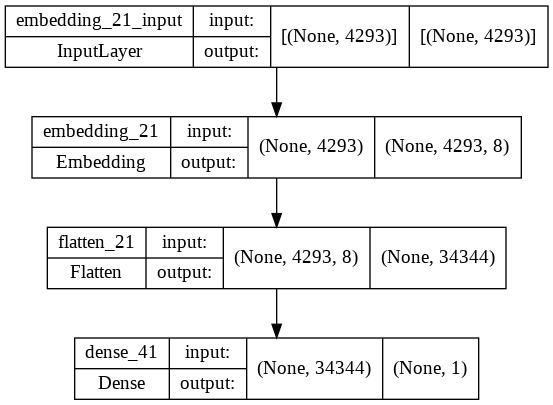

In [ ]:
mcti_NN_Model = Sequential()
mcti_NN_Model.add(Embedding(vocab_size, 8, input_length=len(MCTIinput_vector[0])))
mcti_NN_Model.add(Flatten())
mcti_NN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_NN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti NN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
callbacks_list = [checkpoint, earlystop]

mcti_NN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_NN_MCTI = mcti_NN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
[modelloss, modelaccuracy, 
modelf1, modelprecision, 
modelrecall] = mcti_NN_Model.evaluate(x_testMCTI, y_testMCTI, verbose=0)
print('Accuracy: %f' % (modelaccuracy*100))

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6924 - accuracy: 0.5312 - f1_m: 0.6703 - precision_m: 0.5351 - recall_m: 0.8971
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti NN.h5
2/2 [==============================] - 1s 257ms/step - loss: 0.6823 - accuracy: 0.5625 - f1_m: 0.7150 - precision_m: 0.5777 - recall_m: 0.9385 - val_loss: 0.6529 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6884 - accuracy: 0.5625 - f1_m: 0.7172 - precision_m: 0.5591 - recall_m: 1.0000
Epoch 2: val_accuracy did not improve from 0.65385
2/2 [==============================] - 0s 38ms/step - loss: 0.6783 - accuracy: 0.5913 - f1_m: 0.7407 - precision_m: 0.5887 - recall_m: 1.0000 - val_loss: 0.6852 - val_accuracy: 0.5577 - val_f1_m: 0.6667 - val_precision_m: 0.6571 - val_recall_m: 0.6765
Epoch 3/100
1/2 [==============>...............] - ET

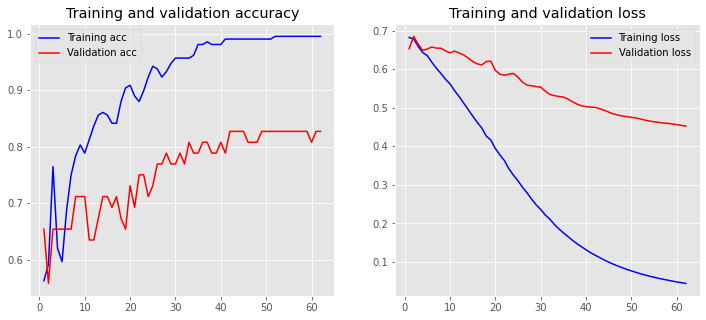

In [ ]:
plot_history(history_NN_MCTI)

###DNN###

In [ ]:
mcti_DNN_Model = Sequential()
mcti_DNN_Model.add(Embedding(vocab_size, 8, input_length=len(MCTIinput_vector[0])))
mcti_DNN_Model.add(Dense(512))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(256))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(128))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Flatten())
mcti_DNN_Model.add(Dense(1, activation='sigmoid'))

#keras.utils.plot_model(mcti_DNN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti DNN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_DNN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_DNN_MCTI = mcti_DNN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
[modelloss, modelaccuracy, 
modelf1, modelprecision, 
modelrecall] = mcti_DNN_Model.evaluate(x_testMCTI, y_testMCTI, verbose=0)
print('Accuracy: %f' % (modelaccuracy*100))

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.4808 - f1_m: 0.3812 - precision_m: 0.7750 - recall_m: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti DNN.h5
2/2 [==============================] - 1s 460ms/step - loss: 0.6993 - accuracy: 0.4808 - f1_m: 0.3812 - precision_m: 0.7750 - recall_m: 0.5135 - val_loss: 0.6768 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.5673 - f1_m: 0.7301 - precision_m: 0.5758 - recall_m: 1.0000
Epoch 2: val_accuracy did not improve from 0.65385
2/2 [==============================] - 0s 140ms/step - loss: 0.6822 - accuracy: 0.5673 - f1_m: 0.7301 - precision_m: 0.5758 - recall_m: 1.0000 - val_loss: 0.6392 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 3/100
2/2 [==============================] - 

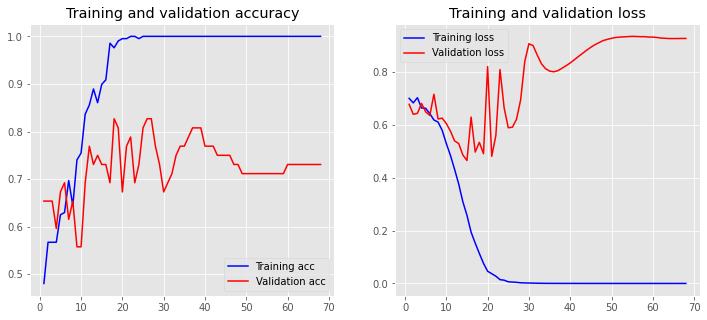

In [ ]:
plot_history(history_DNN_MCTI)

###CNN###

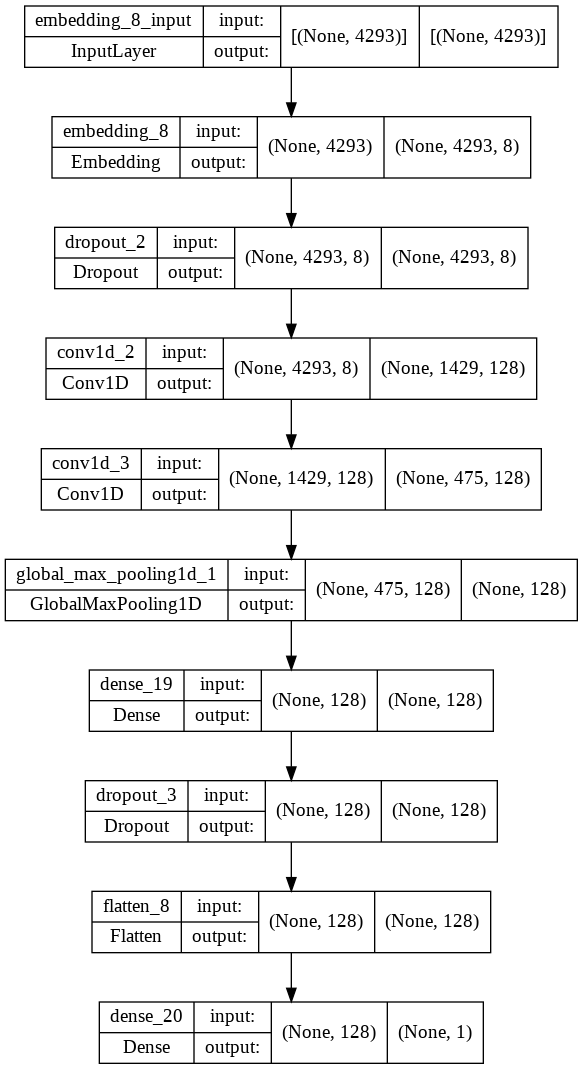

In [ ]:
mcti_CNN_Model = Sequential()
mcti_CNN_Model.add(Embedding(vocab_size, 8, input_length=len(MCTIinput_vector[0])))
mcti_CNN_Model.add(Dropout(0.5))

# Conv1D + global max pooling
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
mcti_CNN_Model.add(Dense(128, activation="relu"))
mcti_CNN_Model.add(Dropout(0.5))

mcti_CNN_Model.add(Flatten())
mcti_CNN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_CNN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti CNN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_CNN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                       metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_CNN_MCTI = mcti_CNN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
[modelloss, modelaccuracy, 
modelf1, modelprecision, 
modelrecall] = mcti_CNN_Model.evaluate(x_testMCTI, y_testMCTI, verbose=0)
print('Accuracy: %f' % (modelaccuracy*100))

Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.6938 - accuracy: 0.5000 - f1_m: 0.5152 - precision_m: 0.5484 - recall_m: 0.4857
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti CNN.h5
2/2 [==============================] - 2s 802ms/step - loss: 0.6911 - accuracy: 0.5433 - f1_m: 0.6355 - precision_m: 0.5780 - recall_m: 0.7429 - val_loss: 0.6820 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6881 - accuracy: 0.5625 - f1_m: 0.7200 - precision_m: 0.5625 - recall_m: 1.0000
Epoch 2: val_accuracy did not improve from 0.65385
2/2 [==============================] - 0s 75ms/step - loss: 0.6853 - accuracy: 0.5673 - f1_m: 0.7251 - precision_m: 0.5688 - recall_m: 1.0000 - val_loss: 0.6730 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 3/100
1/2 [==============>...............] - E

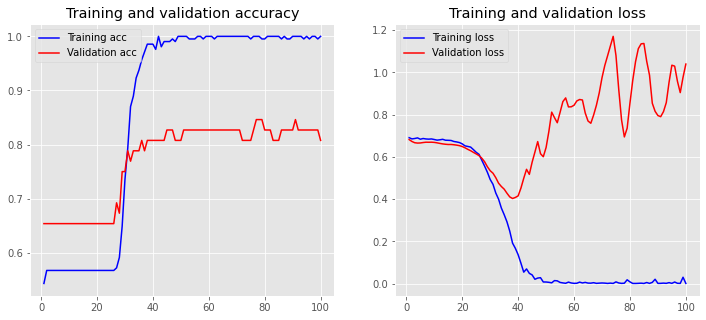

In [ ]:
plot_history(history_CNN_MCTI)

###LSTM###

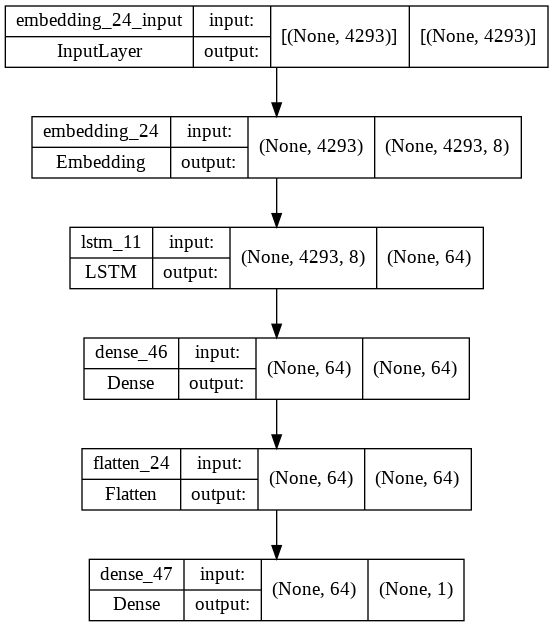

In [ ]:
mcti_LSTM_Model = Sequential()
mcti_LSTM_Model.add(Embedding(vocab_size, 8, input_length=len(MCTIinput_vector[0])))
mcti_LSTM_Model.add(LSTM(64))
mcti_LSTM_Model.add(Dense(64, activation='relu'))
mcti_LSTM_Model.add(Flatten())
mcti_LSTM_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_LSTM_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti LSTM.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_LSTM_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_LSTM_MCTI = mcti_LSTM_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
[modelloss, modelaccuracy, 
modelf1, modelprecision, 
modelrecall] = mcti_LSTM_Model.evaluate(x_testMCTI, y_testMCTI, verbose=0)
print('Accuracy: %f' % (modelaccuracy*100))

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5721 - f1_m: 0.7193 - precision_m: 0.5788 - recall_m: 0.9500
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti LSTM.h5
2/2 [==============================] - 3s 766ms/step - loss: 0.6926 - accuracy: 0.5721 - f1_m: 0.7193 - precision_m: 0.5788 - recall_m: 0.9500 - val_loss: 0.6894 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5673 - f1_m: 0.7269 - precision_m: 0.5711 - recall_m: 1.0000
Epoch 2: val_accuracy did not improve from 0.65385
2/2 [==============================] - 0s 237ms/step - loss: 0.6906 - accuracy: 0.5673 - f1_m: 0.7269 - precision_m: 0.5711 - recall_m: 1.0000 - val_loss: 0.6849 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 3/100
2/2 [==============================] -

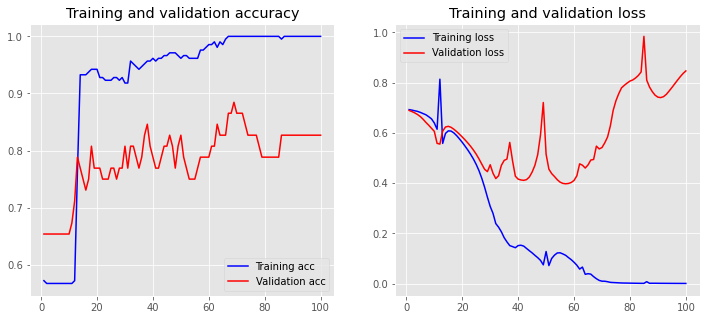

In [ ]:
plot_history(history_LSTM_MCTI)

##EVALUATING THE MODELS##

In [ ]:
#path = "/content/drive/MyDrive/Mestrado/Resultados/best weights mcti NN 82%.h5"
path = "best weights mcti NN.h5"

reconstructed_model_NN = keras.models.load_model(path, 
                                                 custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_NN.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy NN: %f' % (accuracy*100))
print('f1_score NN: %f' % (f1_score*100))
print('precision NN: %f' % (precision*100))
print('recall NN: %f' % (recall*100))

Accuracy NN: 82.692307
f1_score NN: 86.195284
precision NN: 82.121217
recall NN: 91.287881


In [ ]:
#path = "/content/drive/MyDrive/Mestrado/Resultados/best weights mcti NN 82%.h5"
path = "best weights mcti DNN.h5"

reconstructed_model_DNN = keras.models.load_model(path, 
                                                 custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_DNN.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy DNN: %f' % (accuracy*100))
print('f1_score DNN: %f' % (f1_score*100))
print('precision DNN: %f' % (precision*100))
print('recall DNN: %f' % (recall*100))

Accuracy DNN: 82.692307
f1_score DNN: 86.499989
precision DNN: 89.529914
recall DNN: 84.469700


In [ ]:
#path = "/content/drive/MyDrive/Mestrado/Resultados/best weights mcti NN 82%.h5"
path = "best weights mcti CNN.h5"

reconstructed_model_CNN = keras.models.load_model(path, 
                                                 custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_CNN.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy CNN: %f' % (accuracy*100))
print('f1_score CNN: %f' % (f1_score*100))
print('precision CNN: %f' % (precision*100))
print('recall CNN: %f' % (recall*100))

Accuracy CNN: 84.615386
f1_score CNN: 87.559801
precision CNN: 100.000000
recall CNN: 78.030300


In [ ]:
path = "/content/drive/MyDrive/Mestrado/Resultados/best weights mcti LSTM 82.h5"
#path = "best weights mcti LSTM.h5"

reconstructed_model_LSTM = keras.models.load_model(path, 
                                                 custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_LSTM.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy LSTM: %f' % (accuracy*100))
print('f1_score LSTM: %f' % (f1_score*100))
print('precision LSTM: %f' % (precision*100))
print('recall LSTM: %f' % (recall*100))

Accuracy LSTM: 82.692307
f1_score LSTM: 86.752129
precision LSTM: 82.763970
recall LSTM: 91.287881
